In [70]:
import nfl_data_py as nfl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tqdm

In [9]:
# Fetch play-by-play data for multiple seasons
seasons = range(2018, 2024)  # Adjust the range as needed

pbp_data = nfl.import_pbp_data(seasons)

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [296]:
# Select relevant features for your state representation
relevant_features = ['down', 'ydstogo', 'yardline_100', 'score_differential', 'qtr', 'time', 'posteam', 'defteam', 'play_type']
filtered_data = pbp_data[relevant_features].dropna()

scaler = MinMaxScaler()
filtered_data['yardline_100_normalized'] = scaler.fit_transform(filtered_data[['yardline_100']])
le = LabelEncoder()
filtered_data['posteam_transformed'] = le.fit_transform(filtered_data['posteam'])
filtered_data['defteam_transformed'] = le.fit_transform(filtered_data['defteam'])
filtered_data['score_differential_normalized'] = scaler.fit_transform(filtered_data[['score_differential']])

# only keep plays that are either a pass or a run
filtered_data = filtered_data[filtered_data['play_type'].isin(['pass', 'run'])]

def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

filtered_data['time_normalized'] = filtered_data['time'].apply(time_to_seconds)

# Step 2: Normalize the `time_seconds` column
filtered_data['time_normalized'] = filtered_data['time_normalized'] / 900

filtered_data

,down,ydstogo,yardline_100,score_differential,qtr,time,posteam,defteam,play_type,yardline_100_normalized,posteam_transformed,defteam_transformed,score_differential_normalized,time_normalized
3,1.0,15.0,80.0,0.0,1.0,15:00,ATL,PHI,pass,0.806122,1,25,0.528302,1.000000
4,2.0,5.0,70.0,0.0,1.0,14:22,ATL,PHI,run,0.704082,1,25,0.528302,0.957778
5,1.0,10.0,59.0,0.0,1.0,13:46,ATL,PHI,run,0.591837,1,25,0.528302,0.917778
6,1.0,10.0,39.0,0.0,1.0,13:10,ATL,PHI,pass,0.387755,1,25,0.528302,0.877778
7,2.0,10.0,39.0,0.0,1.0,13:05,ATL,PHI,pass,0.387755,1,25,0.528302,0.872222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291087,2.0,6.0,37.0,-3.0,5.0,02:48,KC,SF,pass,0.367347,15,28,0.500000,0.186667
291088,3.0,1.0,32.0,-3.0,5.0,02:07,KC,SF,run,0.316327,15,28,0.500000,0.141111
291089,1.0,10.0,13.0,-3.0,5.0,01:26,KC,SF,run,0.122449,15,28,0.500000,0.095556
291090,2.0,7.0,10.0,-3.0,5.0,00:50,KC,SF,pass,0.091837,15,28,0.500000,0.055556


In [300]:
import numpy as np

class NFLEnvironment:
    def __init__(self, data, test=False):
        self.data = data
        self.current_index = np.random.randint(0, len(data))
        self.test = test
        if self.test:
            self.current_index = 0

    def reset(self):
        self.current_index = np.random.randint(0, len(self.data))
        if self.test:
            self.current_index = 0
        return self._get_state()

    def step(self, action):
        reward = self._calculate_reward(action)
        if self.test:        
            self.current_index += 1
        else:
            self.current_index = np.random.randint(0, len(self.data))
        done = self.current_index >= len(self.data)
        state = self._get_state()
        return state, reward, done, {}

    def _get_state(self):
        try:
            val_to_return = self.data.iloc[self.current_index][['down', 'ydstogo', 'yardline_100_normalized', 'score_differential_normalized', 'qtr', 'time_normalized', 'posteam_transformed', 'defteam_transformed']].values.astype(float)
            
            return val_to_return
        except IndexError:
            print(self.current_index)
            return None

    def _calculate_reward(self, action):
        true_play = self.data.iloc[self.current_index]['play_type']
        action = 'pass' if action == 1 else 'run'
        return 1 if action == true_play else -1

In [261]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [260]:
class PPO:
    def __init__(self, env, policy_net, value_net, learning_rate=3e-4, clip_epsilon=0.2):
        self.env = env
        self.policy_net = policy_net
        self.value_net = value_net
        self.optimizer = torch.optim.Adam(list(policy_net.parameters()) + list(value_net.parameters()), lr=learning_rate)
        self.clip_epsilon = clip_epsilon
        self.ppo_epochs = 10
        self.rewards_list = []

    def collect_trajectories(self, num_steps):
        states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []
        state = self.env.reset()
        
        for _ in range(num_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = self.policy_net(state_tensor)
            value = self.value_net(state_tensor)
            
            action = torch.multinomial(action_probs, 1).item()
            log_prob = torch.log(action_probs[0, action])
            
            next_state, reward, done, _ = self.env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_probs.append(log_prob)
            values.append(value)
            
            state = next_state
            if done:
                state = self.env.reset()
        
        return states, actions, rewards, dones, log_probs, values

    def update(self, states, actions, rewards, dones, old_log_probs, old_values):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        old_log_probs = torch.stack(old_log_probs)
        old_values = torch.cat(old_values)

        # Compute returns and advantages
        returns = self.compute_returns(rewards, dones)
        advantages = returns - old_values

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update loop
        for _ in range(self.ppo_epochs):
            states = states.detach()
            actions = actions.detach()
            old_log_probs = old_log_probs.detach()
            advantages = advantages.detach()
            returns = returns.detach()
            
            # Get new action probabilities and values
            new_action_probs = self.policy_net(states)
            new_values = self.value_net(states).squeeze()

            # Compute ratio and surrogate loss
            new_log_probs = torch.log(new_action_probs.gather(1, actions.unsqueeze(1))).squeeze()
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Compute value loss
            value_loss = nn.MSELoss()(new_values, returns)

            # Compute total loss
            loss = policy_loss + 0.5 * value_loss

            # Perform backpropagation and optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def compute_returns(self, rewards, dones, gamma=0.99):
        returns = []
        R = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + gamma * R * (1 - float(done))
            returns.insert(0, R)
        self.rewards_list.append(sum(rewards))
        return torch.FloatTensor(returns)

    def train(self, num_epochs, batch_size):
        self.ppo_epochs = num_epochs
        for epoch in tqdm.trange(num_epochs):
            trajectories = self.collect_trajectories(batch_size)
            self.update(*trajectories)

    def predict_play(self, state):
        with torch.no_grad():
            action_probs = self.policy_net(torch.FloatTensor(state))
        return action_probs.argmax().item()

In [301]:
# Initialize environment and networks
env = NFLEnvironment(filtered_data)
state_dim = len(env._get_state())
action_dim = 2  # Assuming binary classification (run or pass)

policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)
ppo_agent = PPO(env, policy_net, value_net)

def create_agent(learning_rate=3e-4, clip_epsilon=0.2):
    env = NFLEnvironment(filtered_data)
    state_dim = len(env._get_state())
    action_dim = 2  # Assuming binary classification (run or pass)

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)
    ppo_agent = PPO(env, policy_net, value_net, learning_rate=learning_rate, clip_epsilon=clip_epsilon)
    return ppo_agent


In [302]:
# Create and train PPO agent
ppo_agent.train(num_epochs=50, batch_size=1024)

100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


In [289]:
# Evaluate the trained agent
def evaluate_agent(agent, env, num_plays=10000):
    correct_predictions = 0
    total_predictions = 0
    state = env.reset()

    for _ in tqdm.trange(num_plays):
        action = agent.predict_play(state)
        next_state, reward, _, _ = env.step(action)
        correct_predictions += (reward == 1)
        total_predictions += 1
        state = next_state

    accuracy = correct_predictions / total_predictions
    return accuracy

accuracy = evaluate_agent(ppo_agent, env, num_plays=10000)
print(f"Play prediction accuracy: {accuracy:.2f}")

100%|██████████| 10000/10000 [00:01<00:00, 9520.66it/s]

Play prediction accuracy: 0.63


In [ ]:
# plot rewards over time
ppo_agent_5 = create_agent()
ppo_agent_5.train(num_epochs=5, batch_size=1024)
ppo_agent_10 = create_agent()
ppo_agent_10.train(num_epochs=10, batch_size=1024)
ppo_agent_100 = create_agent()
ppo_agent_100.train(num_epochs=100, batch_size=1024)

In [285]:
# plot learning rate over time
ppo_agent_1e3 = create_agent(learning_rate=1e-3)
ppo_agent_1e3.train(num_epochs=100, batch_size=1024)
ppo_agent_3e4 = create_agent(learning_rate=3e-4)
ppo_agent_3e4.train(num_epochs=100, batch_size=1024)
ppo_agent_1e4 = create_agent(learning_rate=1e-4)
ppo_agent_1e4.train(num_epochs=100, batch_size=1024)
ppo_agent_3e5 = create_agent(learning_rate=3e-5)
ppo_agent_3e5.train(num_epochs=100, batch_size=1024)

 34%|███▍      | 34/100 [00:26<00:51,  1.29it/s]


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [ ]:
# plot batch size over time
ppo_agent_1024 = create_agent()
ppo_agent_1024.train(num_epochs=100, batch_size=1024)
ppo_agent_512 = create_agent()
ppo_agent_512.train(num_epochs=100, batch_size=512)
ppo_agent_2048 = create_agent()
ppo_agent_2048.train(num_epochs=100, batch_size=2048)

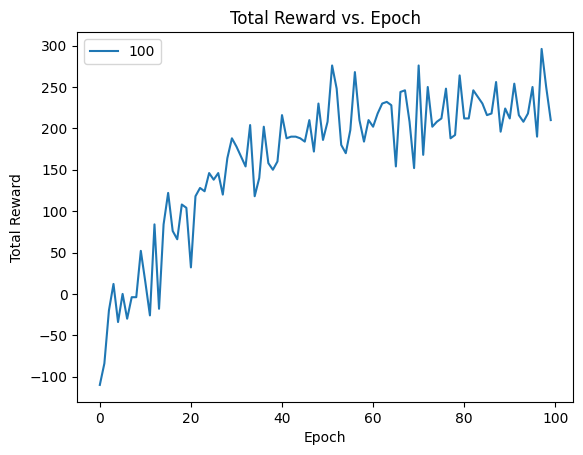

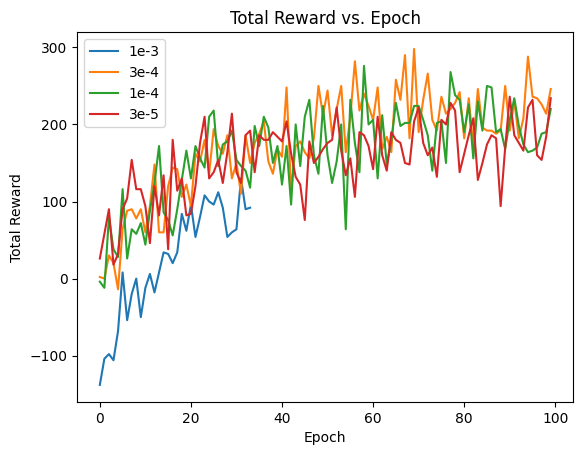

In [309]:
# plot rewards over time
import matplotlib.pyplot as plt

# plot a list of rewards
def plot_rewards(rewards, label):
    for i in range(len(rewards)):
        plt.plot(rewards[i], label=label[i])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs. Epoch')
    plt.show()

plot_rewards([ppo_agent_100.rewards_list], ['100'])
plot_rewards([ppo_agent_1e3.rewards_list, ppo_agent_3e4.rewards_list, ppo_agent_1e4.rewards_list, ppo_agent_3e5.rewards_list], ['1e-3', '3e-4', '1e-4', '3e-5'])


207032
Down 1 accuracy: 0.50
Down 2 accuracy: 0.62
Down 3 accuracy: 0.79
Down 4 accuracy: 0.67


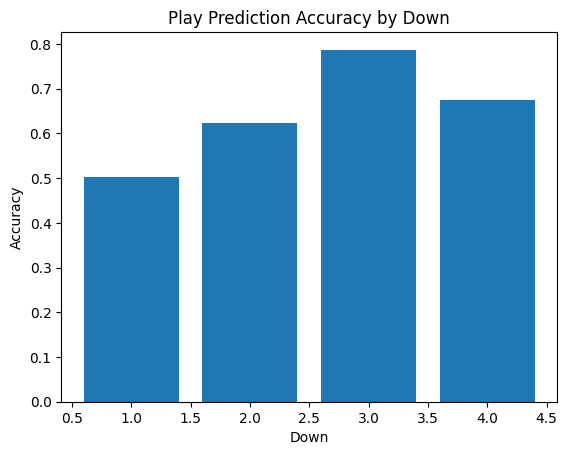

In [303]:
import matplotlib.pyplot as plt

# Analyze prediction accuracy by down
def analyze_by_down(agent, env):
    accuracies = {1: [], 2: [], 3: [], 4: []}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        down = env.data.iloc[env.current_index]['down']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        accuracies[down].append(reward == 1)

    for down, acc in accuracies.items():
        print(f"Down {down} accuracy: {sum(acc)/len(acc):.2f}")

    plt.bar(accuracies.keys(), [sum(acc)/len(acc) for acc in accuracies.values()])
    plt.title("Play Prediction Accuracy by Down")
    plt.xlabel("Down")
    plt.ylabel("Accuracy")
    plt.show()

analyze_by_down(ppo_agent, NFLEnvironment(filtered_data, test=True))

207032
Quarter 1 accuracy: 0.61
Quarter 2 accuracy: 0.64
Quarter 3 accuracy: 0.63
Quarter 4 accuracy: 0.64


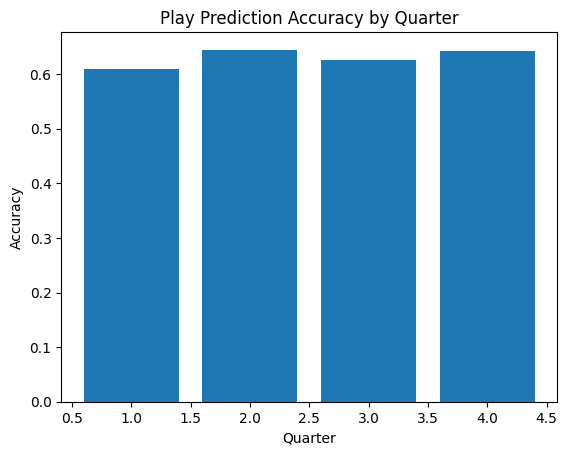

In [292]:
# Analyze prediction accuracy by quarter
def analyze_by_quarter(agent, env):
    accuracies = {1: [], 2: [], 3: [], 4: []}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        quarter = env.data.iloc[env.current_index]['qtr']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        if quarter <= 4:
            accuracies[quarter].append(reward == 1)

    for quarter, acc in accuracies.items():
        print(f"Quarter {quarter} accuracy: {sum(acc)/len(acc):.2f}")

    plt.bar(accuracies.keys(), [sum(acc)/len(acc) for acc in accuracies.values()])
    plt.title("Play Prediction Accuracy by Quarter")
    plt.xlabel("Quarter")
    plt.ylabel("Accuracy")
    plt.show()

analyze_by_quarter(ppo_agent, NFLEnvironment(filtered_data, test=True))

In [322]:
import matplotlib.pyplot as plt

# analyze by team, accuracy vs winning percentage over 2018-2024 seasons

# analyze by team (posteam)
def analyze_by_team(agent, env):
    accuracies = {}
    state = env.reset()

    done = False
    while not done:  # Adjust number of plays to analyze
        team = env.data.iloc[env.current_index]['posteam']
        action = agent.predict_play(state)
        state, reward, done, _ = env.step(action)
        if team not in accuracies:
            accuracies[team] = []
        accuracies[team].append(reward == 1)

    # for team, acc in accuracies.items():
    #     print(f"{team} accuracy: {sum(acc)/len(acc):.2f}")

    return accuracies

accuracies = analyze_by_team(ppo_agent, NFLEnvironment(filtered_data, test=True))

accuracies = {team: sum(acc)/len(acc) for team, acc in accuracies.items()}

207032


In [404]:
# Dependencies
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def resize_image(input_path, output_path, size=(50, 50)):
    img = Image.open(input_path)
    img = img.resize(size)
    img.save(output_path)
    
# Pull the team description 
logos = nfl.import_team_desc()

logos.head()

# Keep only the necessary columns in the logos DataFrame
logos = logos[['team_abbr', 'team_logo_espn']]
# Initialize an empty list for the logo file paths
logo_paths = []

# Initialize an empty list for the team abbreviations
team_abbr = []

# Create a folder for the image files if it doesn't exist

if not os.path.exists("logos"):
    os.makedirs("logos")
# Pull the team logos from the URL and save them in the logos folder, save the file paths to
for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])
# Create a dictionary to put logo_paths and team_abbr in
data = {'team_abbr' : team_abbr, 'Logo Path' : logo_paths}

# Create a DataFrame from the dictionary
logo_df = pd.DataFrame(data)

logo_df.head()

,team_abbr,Logo Path
0,ARI,logos/ARI.tif
1,ATL,logos/ATL.tif
2,BAL,logos/BAL.tif
3,BUF,logos/BUF.tif
4,CAR,logos/CAR.tif


In [388]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(50, 50)):
    img = Image.open(input_path)
    img = img.resize(size)
    img.save(output_path)

# Example usage
input_directory = 'logos'
output_directory = 'logos_resized'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(input_directory):
    if filename.endswith('.tif'):
        resize_image(os.path.join(input_directory, filename), os.path.join(output_directory, filename))

Image size for logos/ATL.tif: 500x500 pixels
Image size for logos/PHI.tif: 500x500 pixels
Image size for logos/BAL.tif: 500x500 pixels
Image size for logos/BUF.tif: 500x500 pixels
Image size for logos/GB.tif: 500x500 pixels
Image size for logos/CHI.tif: 500x500 pixels
Image size for logos/CIN.tif: 500x500 pixels
Image size for logos/IND.tif: 500x500 pixels
Image size for logos/DAL.tif: 500x500 pixels
Image size for logos/CAR.tif: 500x500 pixels
Image size for logos/NE.tif: 500x500 pixels
Image size for logos/HOU.tif: 500x500 pixels
Image size for logos/JAX.tif: 500x500 pixels
Image size for logos/NYG.tif: 500x500 pixels
Image size for logos/LAC.tif: 500x500 pixels
Image size for logos/KC.tif: 500x500 pixels
Image size for logos/LV.tif: 500x500 pixels
Image size for logos/LA.tif: 500x500 pixels
Image size for logos/NYJ.tif: 4096x4096 pixels
Image size for logos/DET.tif: 500x500 pixels
Image size for logos/PIT.tif: 500x500 pixels
Image size for logos/CLE.tif: 500x500 pixels
Image size fo

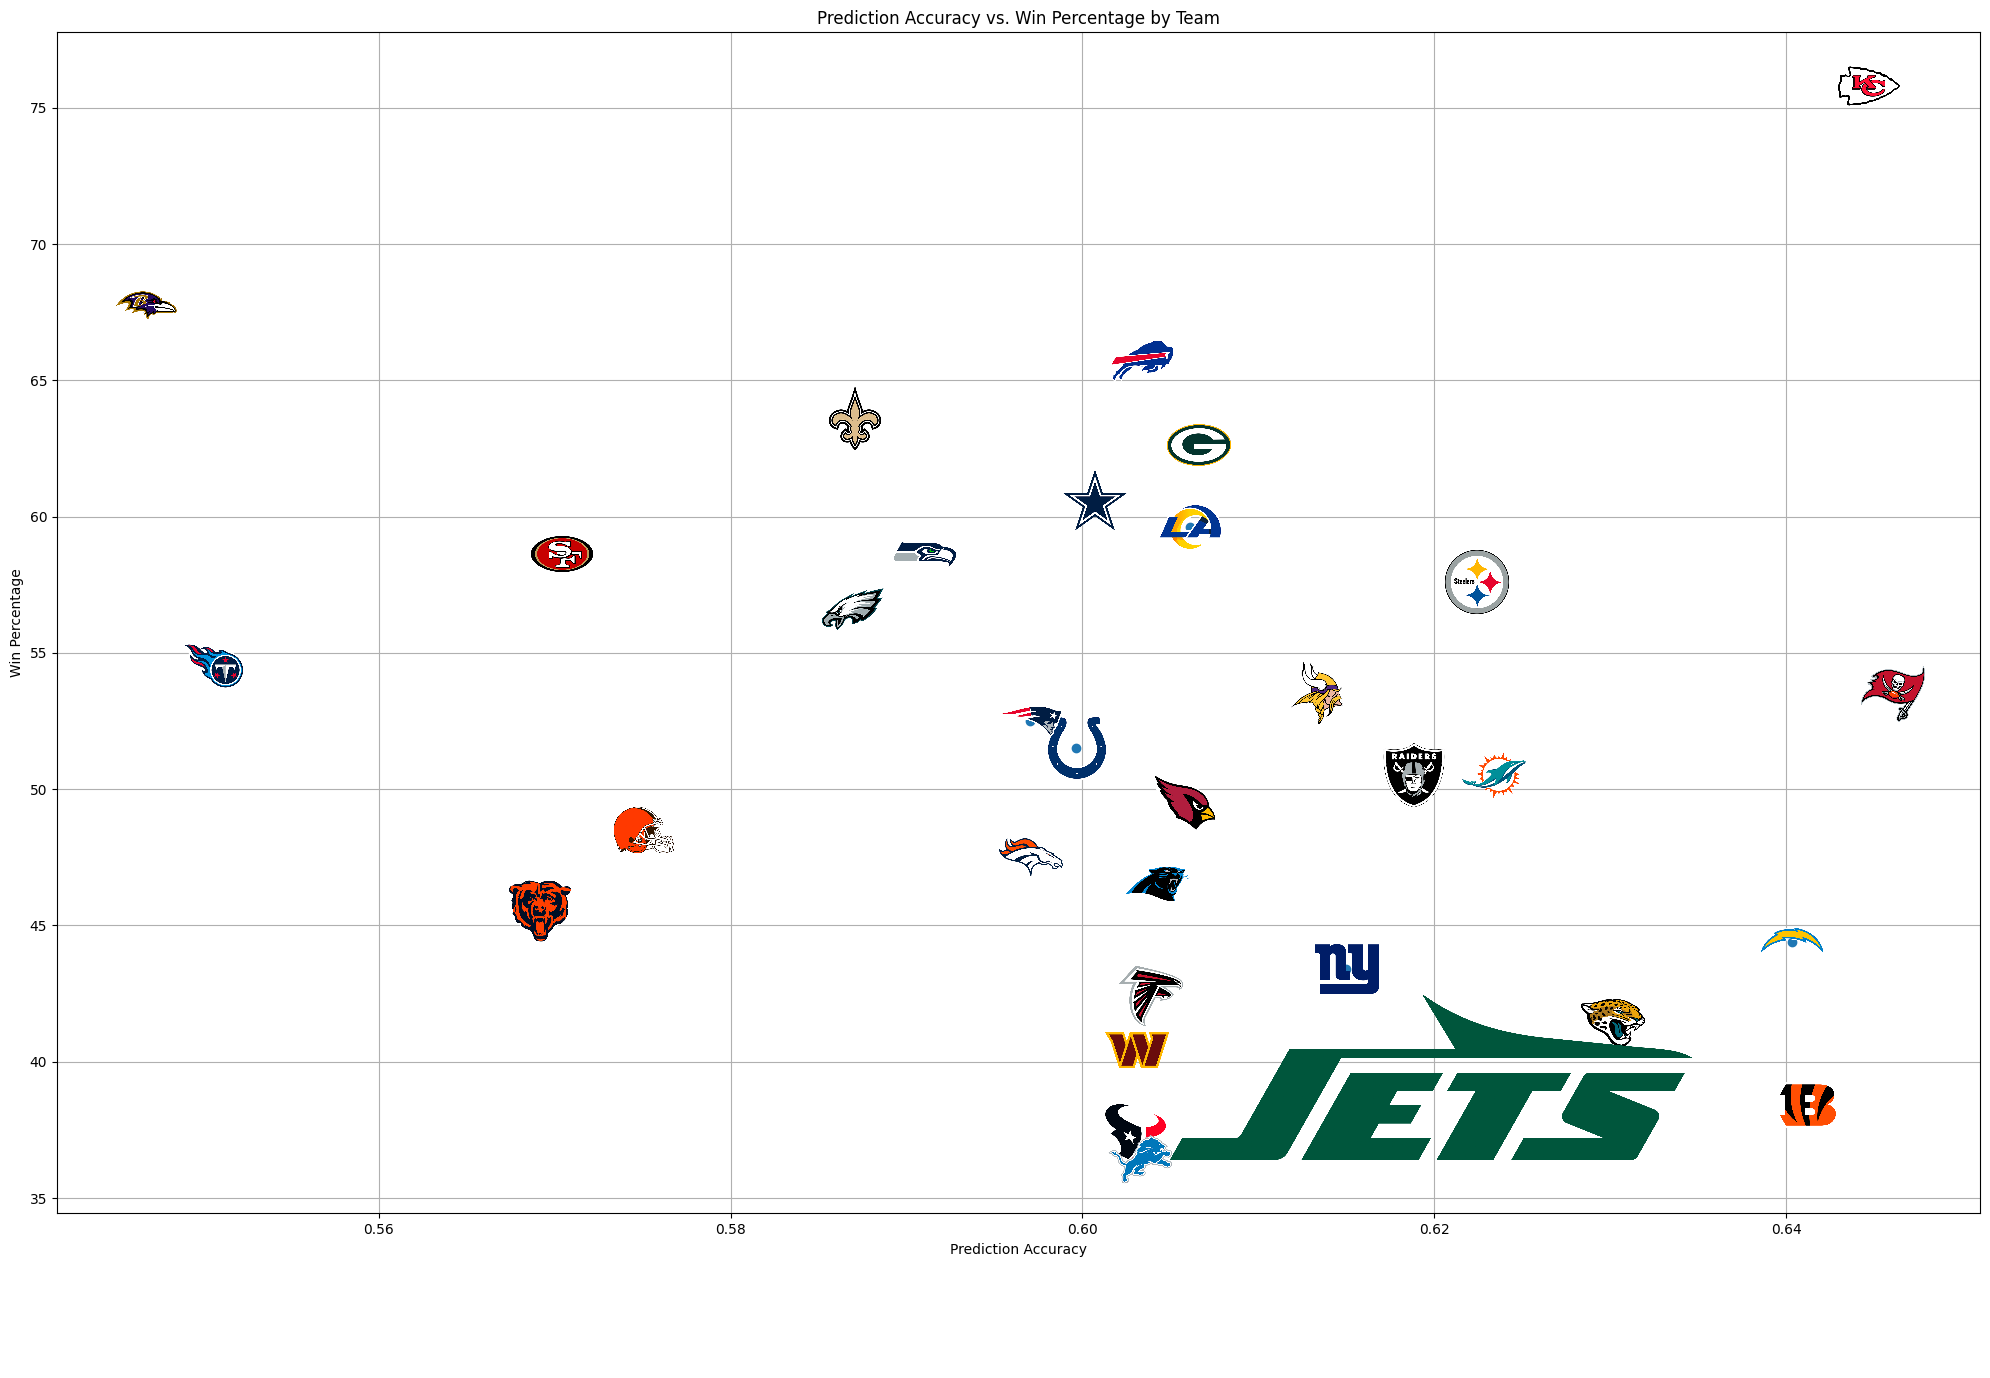

In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request
import io

# Fetch team data to get logos
team_data = nfl.import_team_desc()

# get win percentage from 2018-2024 by team
win_percentage = {
    "KC": 75.8,
    "BAL": 67.7,
    "BUF": 65.7,
    "NO": 63.6,
    "GB": 62.6,
    "DAL": 60.6,
    "LA": 59.6,
    "SF": 58.6,
    "SEA": 58.6,
    "PIT": 57.6,
    "PHI": 56.6,
    "TEN": 54.5,
    "MIN": 53.5,
    "TB": 53.5,
    "NE": 52.5,
    "IND": 51.5,
    "MIA": 50.5,
    "LV": 50.5,
    "ARI": 49.5,
    "CLE": 48.5,
    "DEN": 47.5,
    "CAR": 46.5,
    "CHI": 45.5,
    "LAC": 44.4,
    "NYG": 43.4,
    "ATL": 42.4,
    "JAX": 41.4,
    "WAS": 40.4,
    "NYJ": 39.4,
    "CIN": 38.4,
    "HOU": 37.4,
    "DET": 36.4
}

# create dataframe with accuracy and win percentage
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['team_abbr', 'accuracy'])
team_win_percentage = pd.DataFrame(list(win_percentage.items()), columns=['team_abbr', 'win_percentage'])

merged_df = pd.merge(accuracy_df, team_win_percentage, on='team_abbr')
merged_df = pd.merge(merged_df, logo_df, on='team_abbr')

def getImage(path):
    img = Image.open(path)
    width, height = img.size
    print(f"Image size for {path}: {width}x{height} pixels")
    return OffsetImage(plt.imread(path, format="tif"), zoom=0.1)

plt.rcParams["figure.figsize"] = [20, 14]
plt.rcParams["figure.autolayout"] = True

# Define the x and y variables
x = merged_df['accuracy']
y = merged_df['win_percentage']

# Define the image paths
paths = merged_df['Logo Path']

# Define the plot
fig, ax = plt.subplots()

# Plot the scatter plot
scatter = ax.scatter(x, y)

# Add the logos to the plot
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Set the labels
ax.set_xlabel('Prediction Accuracy')
ax.set_ylabel('Win Percentage')

# Set the title
ax.set_title('Prediction Accuracy vs. Win Percentage by Team')

plt.grid()
# Show the plot
plt.show()



In [403]:
# view all columns 
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pbp_data.iloc[3]

print(pbp_data.columns)
# print all columns
for col in pbp_data.columns:
    print(col)

Index(['play_id', 'game_id', 'old_game_id_x', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'offense_players', 'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type', 'defense_coverage_type'], dtype='object', length=391)
play_id
game_id
old_game_id_x
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaini